<a href="https://colab.research.google.com/github/alexferreira1002/Sionna-RT/blob/main/Syonna_RT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
gpu_num = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try: # detecta se o notebook roda no Colab
    import google.colab
    colab_compat = True # desativar visualização
except:
    colab_compat = False
resolution = [480,320] # aumento para maior qualidade de renderizações

# Permite sair da execução da célula no Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Importa Sionna
try:
    import sionna
except ImportError as e:
    # Instale o Sionna se o pacote ainda não estiver instalado
    import os
    os.system("pip install sionna")
    import sionna

# Configure o notebook para usar apenas uma GPU e alocar apenas a quantidade de memória necessária
# Para obter mais detalhes, consulte https://www.tensorflow.org/guide/gpu

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.get_logger().setLevel('ERROR') # Evite avisos do TensorFlow

tf.random.set_seed(1) # Definir semente aleatória global para reprodutibilidade

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Importar componentes Siona RT
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# Para simulações em nível de link
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [ ]:
from google.colab import drive #Conecta google drive ao notebook
drive.mount("/content/drive", force_remount=True)

In [ ]:
cd '/content/drive/MyDrive/Colab_Notebooks/simulacao'

/content/drive/MyDrive/Colab_Notebooks/simulacao


In [ ]:
# Carregar cena integrada
scene = load_scene("ios2.xml")


In [ ]:
# Muitas vezes é conveniente escolher um ponto de vista na visualização 3D antes de renderizá-lo como uma imagem de alta qualidade.
# Esta célula usa a câmera de “visualização” que corresponde ao ponto de vista da imagem de visualização atual.
if not colab_compat:
    scene.render(camera="preview", num_samples=1024);
else:
    print("Function not available in Colab mode.")


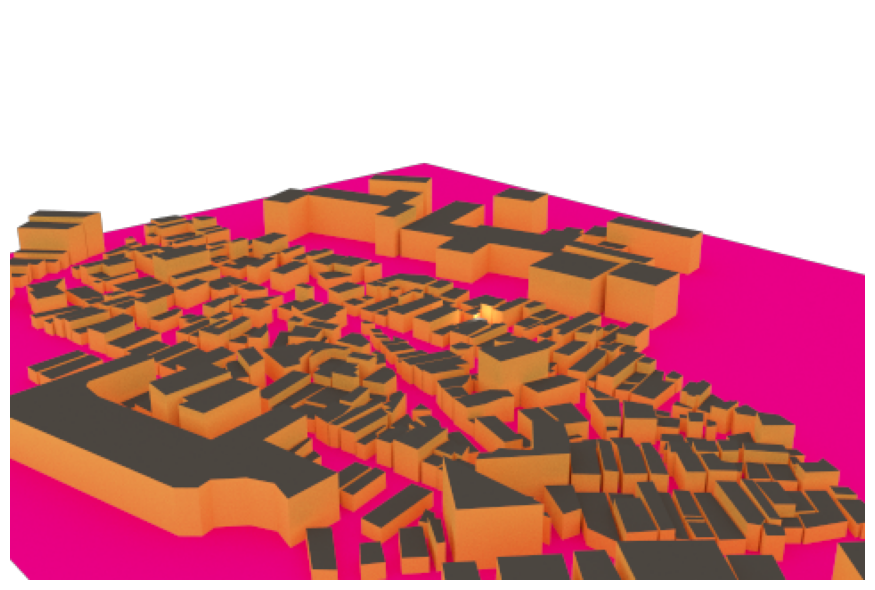

In [ ]:
#Em vez da câmera de visualização, também é possível especificar câmeras dedicadas com diferentes posições e direções de observação.

# Crie uma nova câmera com configuração diferente
my_cam = Camera("my_cam", position=[-250,250,150], look_at=[-15,30,28])
scene.add(my_cam)

# Renderize a cena com nova camara
scene.render("my_cam", resolution=resolution, num_samples=1024); # Aumente num_samples para aumentar a qualidade da imagem

In [ ]:
# Configure o conjunto de antenas para todos os transmissores
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure o conjunto de antenas para todos os receptores
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")
#Criar transmissor
tx = Transmitter(name="tx",
                 position=[-47,-46,25])

# Adiciona instância do transmissor à cena
scene.add(tx)

# Crie um receptor
rx = Receiver(name="rx",
              position=[4,42,21],
              orientation=[0,0,0])

# Adiciona instância do receptor à cena
scene.add(rx)

# Transmissor aponta para o receptor
tx.look_at(rx)

# Definir a frequência portadora da cena e atualizar implicitamente todos os
# RadioMaterials que descreve as propriedades eletromagnéticas do objeto sempre
# que ele interage com um raio. Esse comportamento pode depender da frequência e
# o traçado de raio é feito para uma frequência específica.

# Em Hz; atualiza implicitamente RadioMaterials
scene.frequency = 3.6e9

# Se definido como False, o traçado de raio será feito por elemento de antena
# (mais lento para matrizes grandes)
scene.synthetic_array = True

ExitCell: 

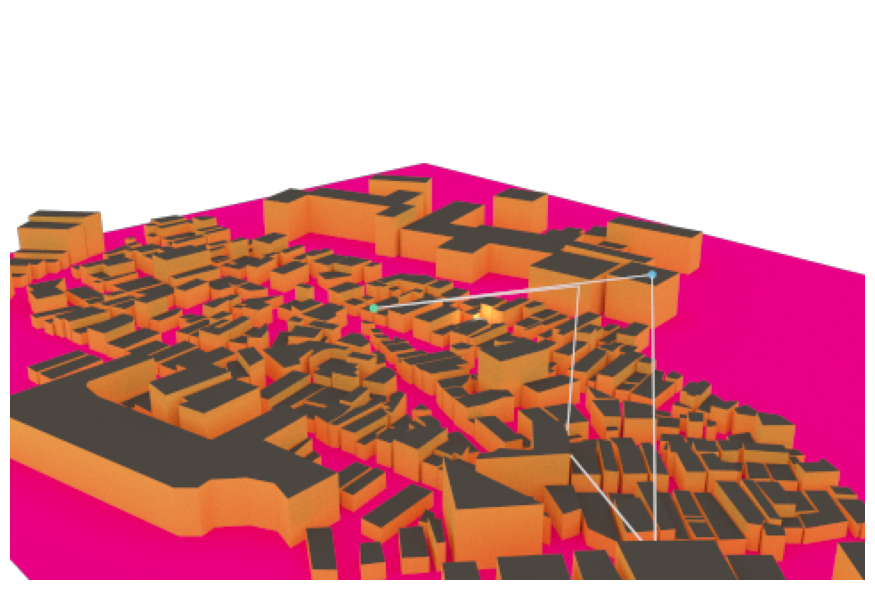

In [ ]:
# Rastreamento de raios e calculo dos caminhos de propagação entre todos os transmissores e receptores.

# Calcular caminhos de propagação
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)  # Número de raios disparados em direções definidas
                                              # por uma esfera de Fibonacci, poucos raios podem  leva a caminhos perdidos


# Visualizar caminhos na visualização 3D
if colab_compat:
    scene.render("my_cam", paths=paths, show_devices=True, show_paths=True, resolution=resolution);
    raise ExitCell
scene.preview(paths, show_devices=True, show_paths=True) # Use o mouse para focar nos caminhos visualizados


In [ ]:
# Mostra as coordenadas dos pontos iniciais de todos os raios.
# Coincidem com a localização dos transmissores.
print("Source coordinates: ", paths.sources.numpy())
print("Transmitter coordinates: ", list(scene.transmitters.values())[0].position.numpy())

# Mostra as coordenadas dos pontos finais de todos os raios.
# Coincidem com a localização dos receptores.
print("Target coordinates: ",paths.targets.numpy())
print("Receiver coordinates: ",list(scene.receivers.values())[0].position.numpy())

# Mostra os tipos de todos os caminhos:
# 0 - LoS, 1 - Refletido, 2 - Difratado, 3 - Espalhado
# Observe que a difração e a dispersão estão desativadas por padrão.
print("Path types: ", paths.types.numpy())


In [ ]:
# Parâmetros padrão no PUSCHConfig
subcarrier_spacing = 15e3
fft_size = 48

In [ ]:
# Imprime a forma dos coeficientes do canal antes da aplicação dos deslocamentos Doppler
# A última dimensão corresponde ao número de intervalos de tempo cujo padrão é um
# pois não há mobilidade
print("Shape of `a` before applying Doppler shifts: ", paths.a.shape)

# Aplicar mudanças Doppler
paths.apply_doppler(sampling_frequency=subcarrier_spacing, # Definir para 15 e 3 Hz
                    num_time_steps=14, # Número de símbolos OFDM
                    tx_velocities=[3.,0,0], # Podemos definir velocidades de tx adicionais
                    rx_velocities=[0,7.,0]) # Ou velocidades rx

print("Shape of `a` after applying Doppler shifts: ", paths.a.shape)

a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

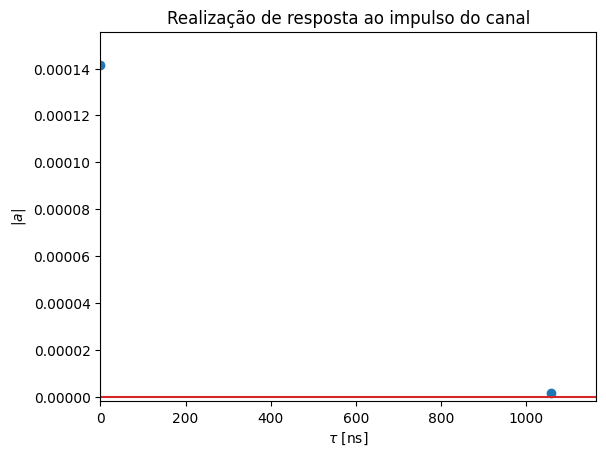

In [ ]:
#resposta ao impulso do canal para os caminhos de entrada da simulação acima.

t = tau[0,0,0,:]/1e-9 #Escalar para ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Adicione uma entrada fictícia no início/fim para uma figura melhor
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# plotar o CIR
plt.figure()
plt.title("Realização de resposta ao impulso do canal")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [ ]:
# Desativa a normalização de atrasos
paths.normalize_delays = False

# Obtenha apenas o caminho LoS
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path without normalization: ", np.squeeze(tau))

paths.normalize_delays = True
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path with normalization: ", np.squeeze(tau))


In [ ]:
# Calcular frequências de subportadoras e centralizar em torno da frequência da portadora
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Calcule a resposta de frequência do canal em frequências.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True) # Não normalizado inclui perda de caminho

# Verifique se a potência do canal está normalizada
h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

print("Shape of h_freq: ", h_freq.shape)
print("Average power h_freq: ", h_avg_power) # O canal está normalizado

In [ ]:
# Espaço reservado para sinal tx de forma
# [tamanho do lote, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
x = tf.zeros([h_freq.shape.as_list()[i] for i in [0,3,4,5,6]], tf.complex64)

no = 0.1 # variação de ruído

# Camada de canal inicial
channel = ApplyOFDMChannel(add_awgn=True)

# Aplicar canal
y = channel([x, h_freq, no])

# [tamanho do lote, num_rx, num_rx_ant, num_ofdm_symbols, fft_size]
print(y.shape)

In [ ]:
# Inicialização push_transmitter
pusch_config = PUSCHConfig()

#  Instancie um PUSCHTransmitter do PUSCHConfig
pusch_transmitter = PUSCHTransmitter(pusch_config)

# Crie um PUSCHReceiver usando o PUSCHTransmitter
pusch_receiver = PUSCHReceiver(pusch_transmitter)

In [ ]:
# Simular transmissões
batch_size = 100 # h_freq é transmitido, ou seja, o mesmo CIR para todas as amostras, mas diferentes realizações de AWGN
ebno_db = 2. # SNR em dB

no = ebnodb2no(ebno_db,
               pusch_transmitter._num_bits_per_symbol,
               pusch_transmitter._target_coderate,
               pusch_transmitter.resource_grid)

x, b = pusch_transmitter(batch_size) # Gerar sinal de transmissão e bits de informação

y = channel([x, h_freq, no]) # Simular saída do canal

b_hat = pusch_receiver([y, no]) # Recupere os bits de informação

# Calcular BER
print(f"BER: {compute_ber(b, b_hat).numpy():.5f}")


In [ ]:
max_depths = 10 # avaliar o desempenho em até 10 reflexões
depths = range(1,max_depths+1)
ts = []
pl_avg = []
for d in depths:
    # salvar horário de início
    t = time.time()
    # execute o traçador de raio
    paths = scene.compute_paths(max_depth=d)
    # meça o intervalo de tempo necessário
    ts.append(time.time()-t)


In [ ]:
# plotar resultados
plt.figure()
plt.plot(depths, ts, color="b");
plt.xlabel("Max. depth")
plt.ylabel("Runtime (s)", color="b")
plt.grid(which="both")
plt.xlim([1, max_depths]);